In [94]:
import os

if os.name == 'posix':
	!python3 -m venv venv
	!source venv/bin/activate && pip3 install -r requirements.txt
if os.name == 'nt':
	!python -m venv venv
	!venv\Scripts\activate && pip install -r requirements.txt
	


In [95]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk

nltk.download('punkt')     # для токенизации
nltk.download('stopwords')  # для списка стоп-слов

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

[nltk_data] Downloading package punkt to /home/sergey/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/sergey/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Текстовый анализ

In [98]:
df = pd.read_excel(r'content/Данные от экспертов (3).xlsx')
df.head()

,Длительность,Простои,Причина,Общее описание
0,20.416666,Переналадки,Переход продукт вода продукт,Переход продукт вода продукт + АПМ
1,21.700000,Переналадки,Переход продукт вода продукт,Переход продукт вода продукт + АПМ
2,29.433333,Прочие внеплановые простои,Загруженность склада,Съем ГП
3,8.733333,Прочие внеплановые простои,Загруженность склада,Съем ГП
4,2.350000,Прочие внеплановые простои,Загруженность склада,Съем ГП


In [99]:
#чистка от всяких знаков + нижнйи регистр
for i in df.columns[1:]:
    df[i] = df[i].apply(lambda x: re.sub(r'[\d\.\:\)\(\+\-\\\/]', '', x.lower()))
    
#список стоп слов
stopwords = set(stopwords.words("russian"))
#токенизатор который извлекает только слова
tokenizer = RegexpTokenizer(r'\b\w+\b')

def tokenize_fun(text):
    if isinstance(text, str):
        tokens = tokenizer.tokenize(text)
        filtered_tokens = [token for token in tokens if token not in stopwords and len(token) > 1]
        return filtered_tokens
    return []

#токенизирую

for i in df.columns[1:]:
    df[i] = df[i].apply(tokenize_fun)

In [103]:
import pymorphy3

#лемматихатор
morph = pymorphy3.MorphAnalyzer()

def lemmatize_tokens(tokens):
    return [morph.parse(token)[0].normal_form for token in tokens]

for i in df.columns[1:]:
    df[i] = df[i].apply(lemmatize_tokens)

In [104]:
df['combined_text'] = df[['Простои', 'Причина', 'Общее описание']].apply(lambda x: ' '.join(sum(x, [])), axis=1)

In [105]:
df.drop(columns=df.columns[1:-1], inplace=True)

In [106]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df['combined_text'])

#список уникальных слов
uniq_woerds = vectorizer.get_feature_names_out()
frequencies_data = X.toarray()
df[uniq_woerds] = frequencies_data
df.drop('combined_text', axis=1, inplace=True)

In [107]:
from sklearn.cluster import KMeans

In [108]:
df['Длительность_стандартизация'] = (df['Длительность'] - df['Длительность'].mean()) / df['Длительность'].std()  # стандартизация

In [109]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(df.iloc[:, 1:])
df.groupby('cluster')['Длительность'].mean()

cluster
0     18.962925
1     12.829536
2    201.317460
3      9.823090
4     83.800641
Name: Длительность, dtype: float64

In [110]:
#средняя длительность простоев по кластеру
avg_downtime = df.groupby('cluster')['Длительность'].mean()

In [111]:
cluster_colors = {
    0: "blue",
    1: "green",
    2: "red",
    3: "purple",
    4: "orange",
    5: "brown",
    6: "pink"
}

# функция для назначения цвета словам в зависимости от кластера
def color_func(cluster):
    def func(word, font_size, position, orientation, random_state=None, **kwargs):
        return cluster_colors.get(cluster, "black")  # Цвет по номеру кластера
    return func

In [112]:
from wordcloud import WordCloud

df_ex = df.loc[:, df.columns[1:-2]]
df[df['cluster'] == 0].iloc[:, 1:-2]

,апм,бутылкибанк,внеплановый,внешний,вода,время,втора,гп,дезинфекция,дизайн,...,тот,укупор,упак,услуга,цветапечатиакциз,час,шт,щк,экспортпромый,этикетка
0,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
320,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


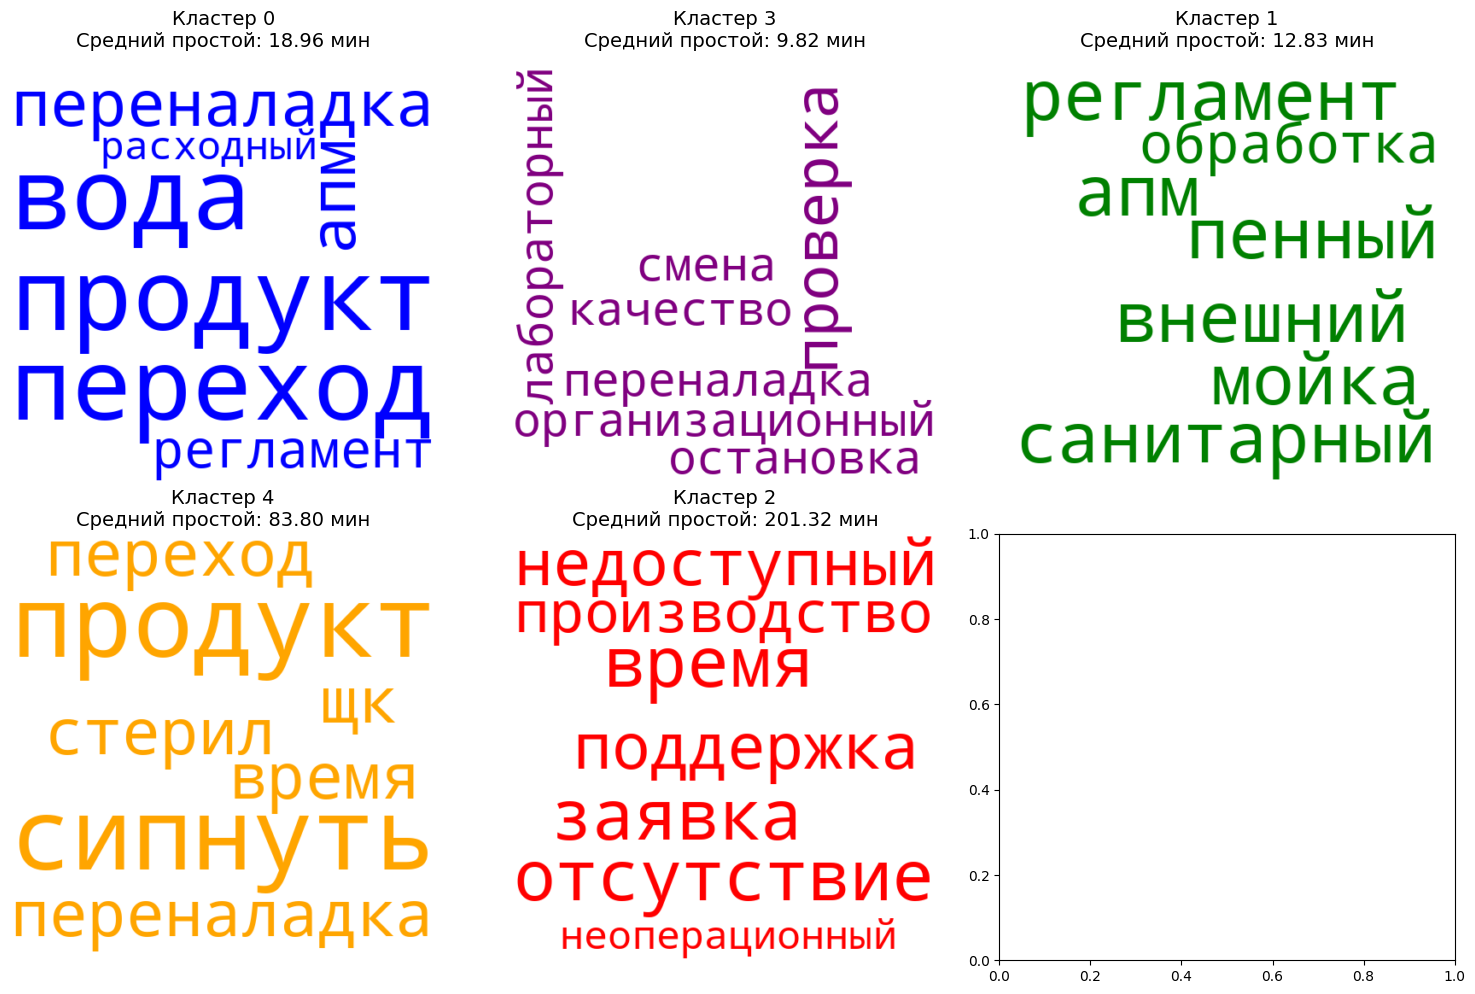

In [114]:
num_clusters = len(df['cluster'].unique())  # Количество кластеров
fig, axes = plt.subplots(2, (num_clusters + 1) // 2, figsize=(15, 10))  # Динамическое количество подграфиков
axes = axes.flatten()


for idx, cluster in enumerate(df['cluster'].unique()):
    df_ex = df[df['cluster'] == cluster].iloc[:, 1:-2]
    top_percent = (((np.sum(df_ex, axis=0))
                     .to_frame())
                     .iloc[:-1, :]
                     .sort_values(by=0, ascending=False))

    # Выбираем топ-10% слов
    top_words = top_percent.iloc[:int(len(top_percent) * 0.1)].index.tolist()
    
    # Создаём строку со словами (повторяем слово в зависимости от его важности)
    word_string = " ".join(top_words)
    
    # Генерируем облако слов
    wordcloud = WordCloud(
        width=500, height=500, 
        background_color="white",
        colormap="viridis",
        color_func=color_func(cluster)
    ).generate(word_string)
    
    # Рисуем облако слов
    axes[idx].imshow(wordcloud, interpolation="bilinear")
    axes[idx].set_title(f"Кластер {cluster}\nСредний простой: {avg_downtime[cluster]:.2f} мин", fontsize=14)
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

# Анализ данных

In [115]:
df_status_declare = pd.read_excel('content/Данные от экспертов.xlsx', sheet_name="Статус по простоям (июль 2024)", header=10)

In [116]:
df_status_declare = df_status_declare[1:]

In [117]:
time_filter = lambda x: x[:-3]
df_status_declare['Время начала интервала'] = df_status_declare['Время начала интервала'].apply(time_filter)
df_status_declare['Время окончания интервала'] = df_status_declare['Время окончания интервала'].apply(time_filter)

In [118]:
df_raw_data = pd.read_excel('content/Данные от экспертов.xlsx', sheet_name="Raw data (июль 2024)", header=9)

In [119]:
df_raw_data = df_raw_data[1:]
df_raw_data

,Unnamed: 0,Время начала интервала,Unnamed: 2,Время окончания интервала,Длительность,Линия,Оборудование,Unnamed: 7,Статус,Unnamed: 9,Заказ,Unnamed: 11,SKU
1,NaN,01/07/2024 08:00,NaN,01/07/2024 08:13,13.4,CL4,Блок розлива (CL4),NaN,Производство > 95%,NaN,NaN,NaN,NaN
2,NaN,01/07/2024 08:13,NaN,01/07/2024 08:13,0.183333,CL4,Блок розлива (CL4),NaN,Вмешательство оператора\n,NaN,NaN,NaN,NaN
3,NaN,01/07/2024 08:13,NaN,01/07/2024 08:18,4.433333,CL4,Блок розлива (CL4),NaN,Производство > 75% < 95%,NaN,NaN,NaN,NaN
4,NaN,01/07/2024 08:18,NaN,01/07/2024 09:17,59.1,CL4,Блок розлива (CL4),NaN,Производство > 95%,NaN,NaN,NaN,NaN
5,NaN,01/07/2024 09:17,NaN,01/07/2024 09:18,1.016666,CL4,Блок розлива (CL4),NaN,Внешняя ошибка,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6640,NaN,31/07/2024 00:18,NaN,31/07/2024 00:48,30.016666,CL4,Блок розлива (CL4),NaN,Производство > 95%,NaN,NaN,NaN,NaN
6641,NaN,31/07/2024 00:48,NaN,31/07/2024 00:50,2,CL4,Блок розлива (CL4),NaN,Производство > 75% < 95%,NaN,NaN,NaN,NaN
6642,NaN,31/07/2024 00:50,NaN,31/07/2024 01:21,31.516666,CL4,Блок розлива (CL4),NaN,Производство > 95%,NaN,NaN,NaN,NaN
6643,NaN,31/07/2024 01:21,NaN,31/07/2024 01:22,0.316666,CL4,Блок розлива (CL4),NaN,Производство > 75% < 95%,NaN,NaN,NaN,NaN


In [120]:
df_raw_data[df_raw_data['Время начала интервала'] == '01/07/2024 11:35']

,Unnamed: 0,Время начала интервала,Unnamed: 2,Время окончания интервала,Длительность,Линия,Оборудование,Unnamed: 7,Статус,Unnamed: 9,Заказ,Unnamed: 11,SKU
36,NaN,01/07/2024 11:35,NaN,01/07/2024 11:55,20.416666,CL4,Блок розлива (CL4),NaN,Вмешательство оператора\n,NaN,NaN,NaN,NaN


In [121]:
df_raw_data[df_raw_data['Время начала интервала'] == '01/07/2024 11:55']

,Unnamed: 0,Время начала интервала,Unnamed: 2,Время окончания интервала,Длительность,Линия,Оборудование,Unnamed: 7,Статус,Unnamed: 9,Заказ,Unnamed: 11,SKU
37,NaN,01/07/2024 11:55,NaN,01/07/2024 11:59,3.6,CL4,Блок розлива (CL4),NaN,Производство < 75%,NaN,NaN,NaN,NaN


In [122]:
_merged = df_status_declare.merge(df_raw_data, on='Время начала интервала')
_merged

,Линия_x,Unnamed: 1,Дата,Смена,Время начала интервала,Время окончания интервала_x,Длительность_x,Unnamed: 7_x,Плановая длительность,Unnamed: 9_x,...,Время окончания интервала_y,Длительность_y,Линия_y,Оборудование_y,Unnamed: 7_y,Статус,Unnamed: 9_y,Заказ,Unnamed: 11,SKU
0,CL4,NaN,01/07/2024,Дневная (08:00-20:00 ),01/07/2024 11:35,01/07/2024 11:55,20.416666,NaN,NaN,NaN,...,01/07/2024 11:55,20.416666,CL4,Блок розлива (CL4),NaN,Вмешательство оператора\n,NaN,NaN,NaN,NaN
1,CL4,NaN,01/07/2024,Дневная (08:00-20:00 ),01/07/2024 15:52,01/07/2024 16:14,21.7,NaN,NaN,NaN,...,01/07/2024 15:52,0.633333,CL4,Блок розлива (CL4),NaN,Производство < 75%,NaN,NaN,NaN,NaN
2,CL4,NaN,01/07/2024,Дневная (08:00-20:00 ),01/07/2024 15:52,01/07/2024 16:14,21.7,NaN,NaN,NaN,...,01/07/2024 16:14,21.7,CL4,Блок розлива (CL4),NaN,Вмешательство оператора\n,NaN,NaN,NaN,NaN
3,CL4,NaN,01/07/2024,Дневная (08:00-20:00 ),01/07/2024 17:52,01/07/2024 18:21,29.433333,NaN,NaN,NaN,...,01/07/2024 18:21,29.433333,CL4,Блок розлива (CL4),NaN,Затор на выходе,NaN,NaN,NaN,NaN
4,CL4,NaN,01/07/2024,Дневная (08:00-20:00 ),01/07/2024 18:22,01/07/2024 18:31,8.733333,NaN,NaN,NaN,...,01/07/2024 18:31,8.733333,CL4,Блок розлива (CL4),NaN,Затор на выходе,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,CL4,NaN,30/07/2024,Ночная (20:00-08:00 ),30/07/2024 21:05,30/07/2024 21:09,3.916666,NaN,NaN,NaN,...,30/07/2024 21:05,0.183333,CL4,Блок розлива (CL4),NaN,Производство > 75% < 95%,NaN,NaN,NaN,NaN
425,CL4,NaN,30/07/2024,Ночная (20:00-08:00 ),30/07/2024 21:05,30/07/2024 21:09,3.916666,NaN,NaN,NaN,...,30/07/2024 21:09,3.916666,CL4,Блок розлива (CL4),NaN,Внешняя ошибка,NaN,NaN,NaN,NaN
426,CL4,NaN,30/07/2024,Ночная (20:00-08:00 ),30/07/2024 21:42,31/07/2024 00:08,146.95,NaN,NaN,NaN,...,31/07/2024 00:08,146.95,CL4,Блок розлива (CL4),NaN,Нехватка на входе,NaN,NaN,NaN,NaN
427,CL4,NaN,30/07/2024,Ночная (20:00-08:00 ),31/07/2024 00:09,31/07/2024 00:11,2.35,NaN,NaN,NaN,...,31/07/2024 00:11,2.35,CL4,Блок розлива (CL4),NaN,Вмешательство оператора\n,NaN,NaN,NaN,NaN


In [123]:
_merged.to_excel('content/merged.xlsx')

# Разделение таблицы статусов новых данных

In [124]:
data = pd.read_excel('content/Поломки_Блок Розлива_2020-2024v2.xlsx')
data

,Начало простоя,Конец простоя,Reason 3 (ID),Reason 3 (ENG),Описание,Длительность
0,08-янв-20 02:04:44,08-янв-20 02:08:29,2010004.0,Breakdowns,Замена двух дросселей на наполнителе №17,3.750000
1,28-янв-20 09:11:45,28-янв-20 09:20:46,2010004.0,Breakdowns,Замена первого ролика на столике №1,9.016667
2,05-фев-20 10:40:01,05-фев-20 10:42:23,2010004.0,Breakdowns,Замена нагнетательного дросселя №89,2.366667
3,06-фев-20 10:59:58,06-фев-20 11:04:09,2010004.0,Breakdowns,Замена нагнетательного дросселя №105,4.183333
4,06-фев-20 19:02:48,06-фев-20 19:05:07,2010004.0,Breakdowns,Замена тормозной пластины №76,2.316667
...,...,...,...,...,...,...
527,04-ноя-24 19:15:34,04-ноя-24 19:17:41,2010004.0,Breakdowns,Замена тормозной пластины на 66 наполнителе,2.100000
528,05-ноя-24 09:48:48,05-ноя-24 09:51:31,2010004.0,Breakdowns,замена тормозной пластины,2.716667
529,21-ноя-24 03:12:49,21-ноя-24 03:16:28,2010004.0,Breakdowns,МЕХ. Недолив. Пустые банки. 20/32/33/39,3.650000
530,21-ноя-24 03:24:45,21-ноя-24 03:28:36,2010004.0,Breakdowns,МЕХ. Недолив. Пустые банки. 20/32/33/39,3.833333


In [125]:
pattern = r'(?:Замена|устранение|не\s+работает|выбивает|залип|остановки|ремонт|заменена|замена|мех\.|кип)(.*?)(?:№|\b№№\b|#|:\s|на\s|по\s)(\d+(?:,\s*\d+)*)'

# Функция для парсинга строки
def parse_description(description):
	try:
		match = re.search(pattern, description, re.IGNORECASE)
		if match:
			element = match.group(1).strip()
			numbers = match.group(2).replace('№', '').replace('#', '').strip() 
			return element.lower(), numbers
		return None, None
	except TypeError:
		return None, None

data[["Элемент", "Номер"]] = data["Описание"].apply(lambda x: pd.Series(parse_description(x)))

# Разделяем номера, если их несколько
data = data.dropna(subset=["Номер"])  # Удаляем строки без найденных номеров
# data["Номер"] = data["Номер"].str.split(',').explode().str.strip()

# Выводим результат
print(data[["Элемент", "Номер"]])

# Сохраняем в CSV файл (если нужно)
data[["Элемент", "Номер"]].to_csv("parsed_data.csv", index=False, encoding="utf-8")

                           Элемент Номер
0    двух дросселей на наполнителе    17
1        первого ролика на столике     1
2         нагнетательного дросселя    89
3         нагнетательного дросселя   105
4               тормозной пластины    76
..                             ...   ...
504                       недолива    71
517                  тор. пластины    63
518                       дросселя    33
526             тормозной пластины    10
527             тормозной пластины    66

[243 rows x 2 columns]


In [126]:
# преобразуем слова в колонке Элементы в Леммы
import pymorphy2

morph = pymorphy2.MorphAnalyzer()


def lemmatize_text(text):
    if not isinstance(text, str):  
        return ''
    words = text.split()  # Разделяем текст на слова
    lemmas = [morph.parse(word)[0].normal_form for word in words]  
    return ' '.join(lemmas)  

data['Элемент'] = data['Элемент'].apply(lemmatize_text)

/tmp/ipykernel_419662/3894660546.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Элемент'] = data['Элемент'].apply(lemmatize_text)


In [127]:
data.drop('Описание', axis=1, inplace=True)

/tmp/ipykernel_419662/2089630613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('Описание', axis=1, inplace=True)


In [128]:
len(data['Элемент'].unique())

68

In [129]:
# Проведём анализ того, насколько долго при каждом элементе происходил простой

sorted_data = data.sort_values(by='Длительность', ascending=False)

<Axes: xlabel='Длительность', ylabel='Элемент'>

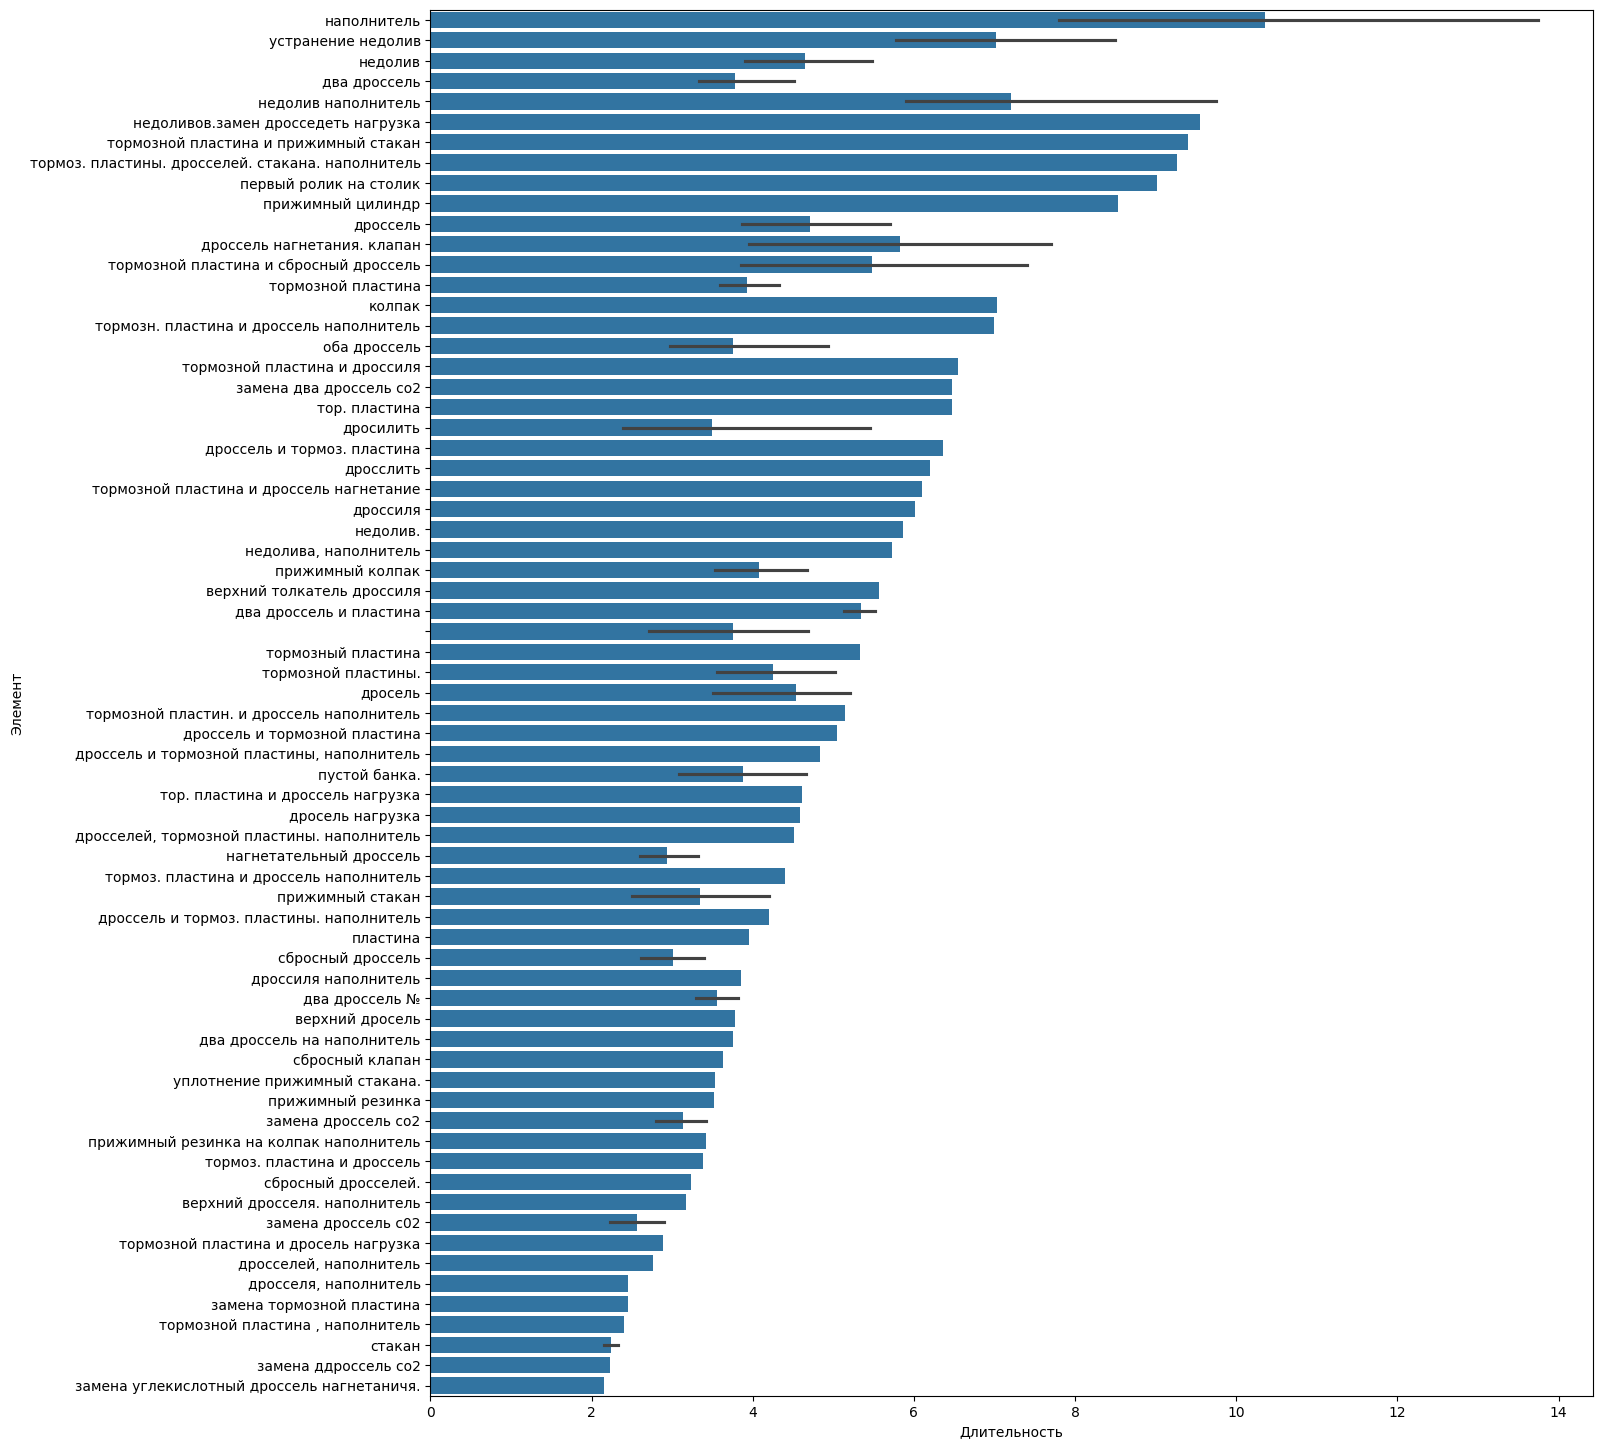

In [130]:
plt.figure(figsize=(15,18))
sns.barplot(x='Длительность', y='Элемент', data=sorted_data)


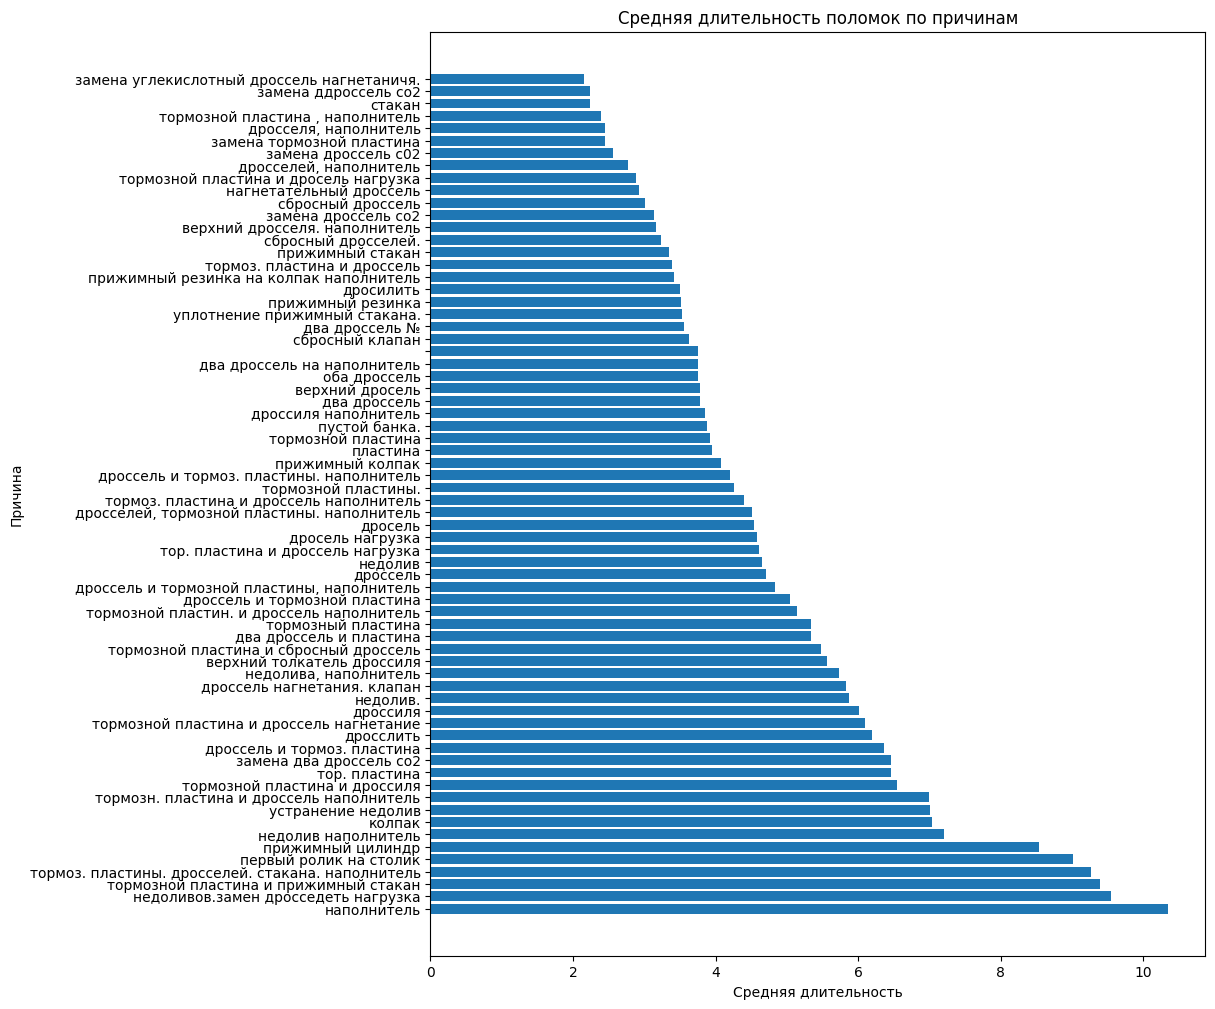

Топ-10 причин по средней длительности:
                                              Элемент  Длительность
31                                        наполнитель     10.355556
36                недоливов.замен дросседеть нагрузка      9.550000
62              тормозной пластина и прижимный стакан      9.400000
54  тормоз. пластины. дросселей. стакана. наполнитель      9.266667
38                             первый ролик на столик      9.016667
44                                  прижимный цилиндр      8.533333
33                                недолив наполнитель      7.200000
29                                             колпак      7.033333
67                                 устранение недолив      7.013333
55           тормозн. пластина и дроссель наполнитель      7.000000


In [131]:
grouped = data.groupby('Элемент')['Длительность'].mean().reset_index()

# Сортировка по средней длительности
sorted_grouped = grouped.sort_values(by='Длительность', ascending=False)

# Визуализация
plt.figure(figsize=(10, 12))
plt.barh(sorted_grouped['Элемент'], sorted_grouped['Длительность'])
plt.xlabel('Средняя длительность')
plt.ylabel('Причина')
plt.title('Средняя длительность поломок по причинам')
plt.show()

# Топ-10 причин по средней длительности
top_10 = sorted_grouped.head(10)
print("Топ-10 причин по средней длительности:")
print(top_10)

In [132]:
# выполним кластеризацию данных по длительности
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data[['Длительность']])
data['cluster'] = kmeans.predict(data[['Длительность']])
data

/tmp/ipykernel_419662/3569028396.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = kmeans.predict(data[['Длительность']])


,Начало простоя,Конец простоя,Reason 3 (ID),Reason 3 (ENG),Длительность,Элемент,Номер,cluster
0,08-янв-20 02:04:44,08-янв-20 02:08:29,2010004.0,Breakdowns,3.750000,два дроссель на наполнитель,17,1
1,28-янв-20 09:11:45,28-янв-20 09:20:46,2010004.0,Breakdowns,9.016667,первый ролик на столик,1,2
2,05-фев-20 10:40:01,05-фев-20 10:42:23,2010004.0,Breakdowns,2.366667,нагнетательный дроссель,89,1
3,06-фев-20 10:59:58,06-фев-20 11:04:09,2010004.0,Breakdowns,4.183333,нагнетательный дроссель,105,1
4,06-фев-20 19:02:48,06-фев-20 19:05:07,2010004.0,Breakdowns,2.316667,тормозной пластина,76,1
...,...,...,...,...,...,...,...,...
504,08-фев-24 00:56:06,08-фев-24 01:01:53,2010004.0,Breakdowns,5.766667,недолив,71,0
517,19-сен-24 00:21:31,19-сен-24 00:28:00,2010004.0,Breakdowns,6.466667,тор. пластина,63,0
518,19-сен-24 00:30:19,19-сен-24 00:34:53,2010004.0,Breakdowns,4.550000,дроссель,33,0
526,04-ноя-24 16:04:20,04-ноя-24 16:07:21,2010004.0,Breakdowns,3.016667,тормозной пластина,10,1


In [133]:
data.to_excel('content/clusterized.xlsx')

In [134]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [135]:
labels

array([1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 2, 0, 1, 1, 1, 0, 1, 0, 0, 1, 2, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 2, 2, 1, 2, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2, 2, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 2, 2, 1, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 2, 1, 0, 0, 1, 2, 0, 1, 1, 0, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1,
       1], dtype=int32)

In [136]:
sorted_data = data.sort_values(by='Длительность', ascending=False)

/tmp/ipykernel_419662/894940618.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=color, label=f'Кластер {cluster}')


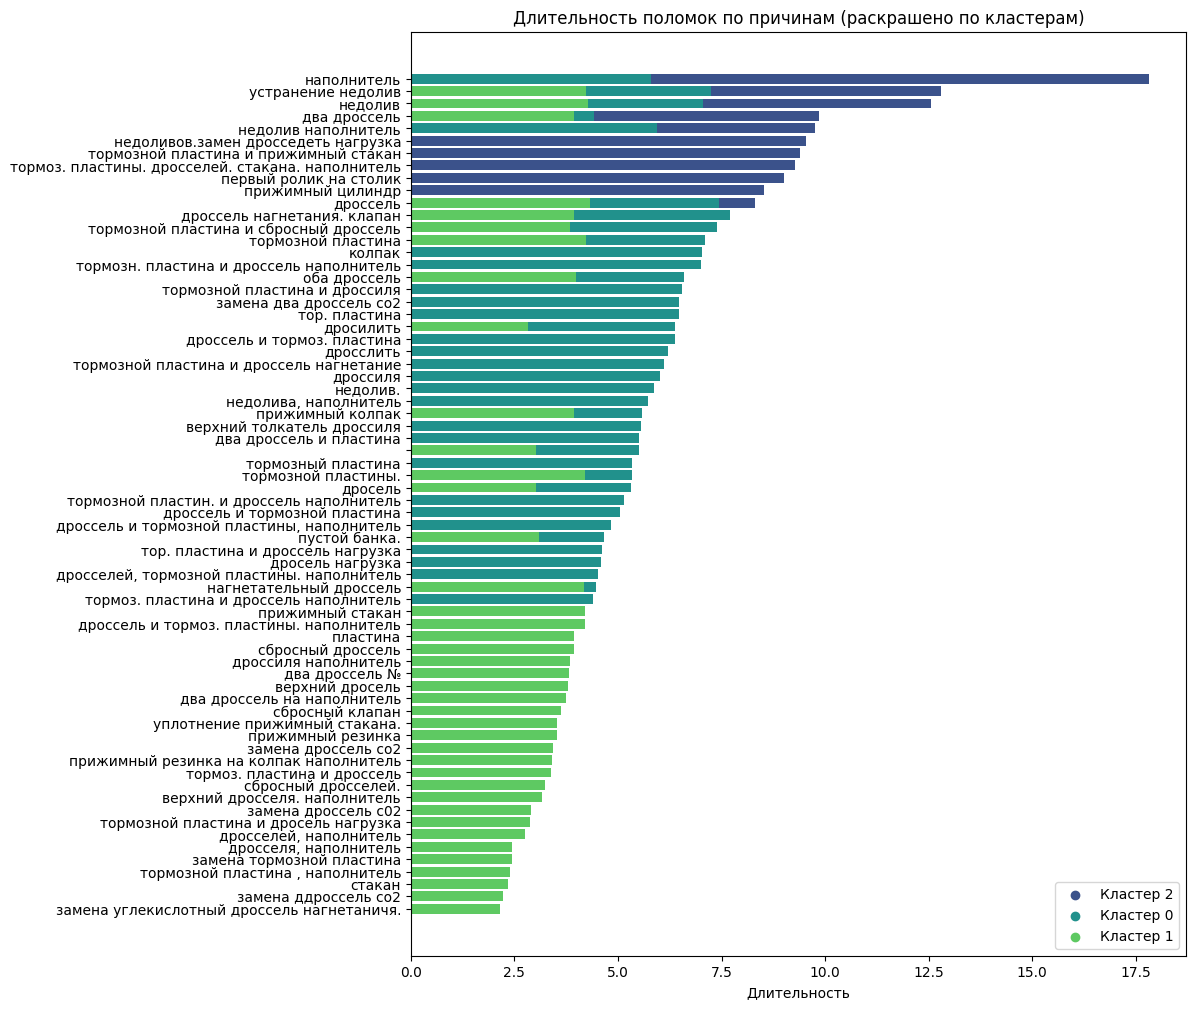

In [137]:
colors = sns.color_palette('viridis', n_colors=len(sorted_data['cluster'].unique()))

color_dict = {cluster: colors[i] for i, cluster in enumerate(sorted_data['cluster'].unique())}

bar_colors = [color_dict[cluster] for cluster in sorted_data['cluster']]

plt.figure(figsize=(10, 12))
plt.barh(sorted_data['Элемент'], sorted_data['Длительность'], color=bar_colors)
plt.xlabel('Длительность')
plt.title('Длительность поломок по причинам (раскрашено по кластерам)')
plt.gca().invert_yaxis()  

for cluster, color in color_dict.items():
    plt.scatter([], [], c=color, label=f'Кластер {cluster}')
plt.legend()
plt.show()

In [138]:
grouped_data = data.groupby('cluster')['Длительность'].mean()
grouped_data

cluster
0     5.602675
1     3.181621
2    10.234375
Name: Длительность, dtype: float64

In [139]:
group_by_sum = data.groupby('cluster')['Длительность'].sum()
group_by_sum

cluster
0    453.816667
1    464.516667
2    163.750000
Name: Длительность, dtype: float64

<Axes: xlabel='Длительность', ylabel='Длительность'>

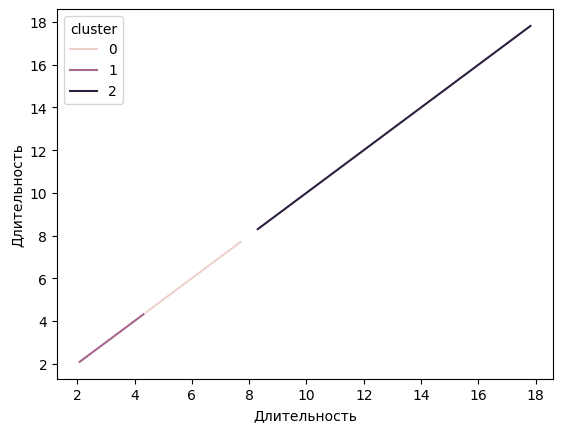

In [140]:
sns.lineplot(x='Длительность', y='Длительность', hue='cluster', data=data)

<Axes: xlabel='Длительность', ylabel='Длительность'>

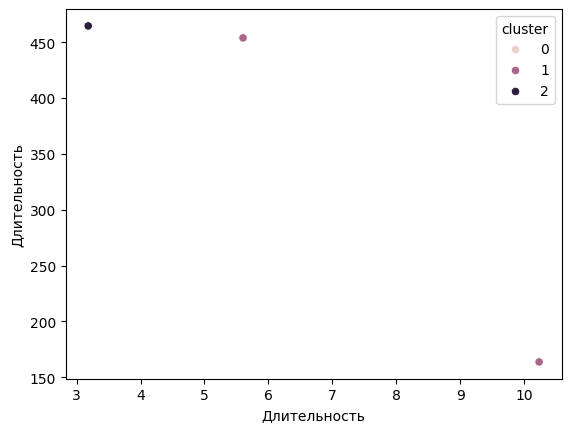

In [141]:
sns.scatterplot(x=data.groupby('cluster')['Длительность'].mean(), y=data.groupby('cluster')['Длительность'].sum(), hue='cluster', data=data)

`Так как кластера всего 3, то 3 точки на графике показывают зависимость суммарной длительности времени простоя от среднего времени простоя по кластеру`

Элементы, `замена которых занимает меньше всего` времени работы конвейра `ломаются чаще всего`

Оценим параметры, которые входят в каждый кластер

In [142]:
data[data['cluster'] == 1]['Элемент']

0        два дроссель на наполнитель
2            нагнетательный дроссель
3            нагнетательный дроссель
4                 тормозной пластина
7                тормозной пластины.
                   ...              
500    верхний дросселя. наполнитель
501                          недолив
502                          недолив
526               тормозной пластина
527               тормозной пластина
Name: Элемент, Length: 146, dtype: object

Введём маркеры времени суток (утро, день, вечер, ночь)

Утро: 06:00 - 12:00  
День: 12:00 - 18:00  
Вечер: 18:00 - 24:00  
Ночь: 00:00 - 06:00  

In [143]:

data['Начало простоя (часы)'] = data['Начало простоя'].apply(lambda x: x.split(' ')[1])
data['Начало простоя (часы)'] = pd.to_datetime(data['Начало простоя (часы)'])

def get_time_of_day(time):
    hour = time.hour
    if 6 <= hour < 12:
        return 'Утро'
    elif 12 <= hour < 18:
        return 'День'
    elif 18 <= hour < 24:
        return 'Вечер'
    else:
        return 'Ночь'


data['Время суток'] = data['Начало простоя (часы)'].apply(lambda x: get_time_of_day(x))
data

/tmp/ipykernel_419662/2559687569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Начало простоя (часы)'] = data['Начало простоя'].apply(lambda x: x.split(' ')[1])
/tmp/ipykernel_419662/2559687569.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Начало простоя (часы)'] = pd.to_datetime(data['Начало простоя (часы)'])
/tmp/ipykernel_419662/2559687569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

,Начало простоя,Конец простоя,Reason 3 (ID),Reason 3 (ENG),Длительность,Элемент,Номер,cluster,Начало простоя (часы),Время суток
0,08-янв-20 02:04:44,08-янв-20 02:08:29,2010004.0,Breakdowns,3.750000,два дроссель на наполнитель,17,1,2025-02-24 02:04:44,Ночь
1,28-янв-20 09:11:45,28-янв-20 09:20:46,2010004.0,Breakdowns,9.016667,первый ролик на столик,1,2,2025-02-24 09:11:45,Утро
2,05-фев-20 10:40:01,05-фев-20 10:42:23,2010004.0,Breakdowns,2.366667,нагнетательный дроссель,89,1,2025-02-24 10:40:01,Утро
3,06-фев-20 10:59:58,06-фев-20 11:04:09,2010004.0,Breakdowns,4.183333,нагнетательный дроссель,105,1,2025-02-24 10:59:58,Утро
4,06-фев-20 19:02:48,06-фев-20 19:05:07,2010004.0,Breakdowns,2.316667,тормозной пластина,76,1,2025-02-24 19:02:48,Вечер
...,...,...,...,...,...,...,...,...,...,...
504,08-фев-24 00:56:06,08-фев-24 01:01:53,2010004.0,Breakdowns,5.766667,недолив,71,0,2025-02-24 00:56:06,Ночь
517,19-сен-24 00:21:31,19-сен-24 00:28:00,2010004.0,Breakdowns,6.466667,тор. пластина,63,0,2025-02-24 00:21:31,Ночь
518,19-сен-24 00:30:19,19-сен-24 00:34:53,2010004.0,Breakdowns,4.550000,дроссель,33,0,2025-02-24 00:30:19,Ночь
526,04-ноя-24 16:04:20,04-ноя-24 16:07:21,2010004.0,Breakdowns,3.016667,тормозной пластина,10,1,2025-02-24 16:04:20,День


In [144]:
# Произведём 0ne-hot кодирование признаков времени суток
one_hotting_df = pd.get_dummies(data['Время суток'])
one_hotting_df

,Вечер,День,Ночь,Утро
0,False,False,True,False
1,False,False,False,True
2,False,False,False,True
3,False,False,False,True
4,True,False,False,False
...,...,...,...,...
504,False,False,True,False
517,False,False,True,False
518,False,False,True,False
526,False,True,False,False


In [145]:
data.drop('Время суток', axis=1, inplace=True)
data = pd.concat([data, one_hotting_df], axis=1)
data

/tmp/ipykernel_419662/4231584830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('Время суток', axis=1, inplace=True)


,Начало простоя,Конец простоя,Reason 3 (ID),Reason 3 (ENG),Длительность,Элемент,Номер,cluster,Начало простоя (часы),Вечер,День,Ночь,Утро
0,08-янв-20 02:04:44,08-янв-20 02:08:29,2010004.0,Breakdowns,3.750000,два дроссель на наполнитель,17,1,2025-02-24 02:04:44,False,False,True,False
1,28-янв-20 09:11:45,28-янв-20 09:20:46,2010004.0,Breakdowns,9.016667,первый ролик на столик,1,2,2025-02-24 09:11:45,False,False,False,True
2,05-фев-20 10:40:01,05-фев-20 10:42:23,2010004.0,Breakdowns,2.366667,нагнетательный дроссель,89,1,2025-02-24 10:40:01,False,False,False,True
3,06-фев-20 10:59:58,06-фев-20 11:04:09,2010004.0,Breakdowns,4.183333,нагнетательный дроссель,105,1,2025-02-24 10:59:58,False,False,False,True
4,06-фев-20 19:02:48,06-фев-20 19:05:07,2010004.0,Breakdowns,2.316667,тормозной пластина,76,1,2025-02-24 19:02:48,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,08-фев-24 00:56:06,08-фев-24 01:01:53,2010004.0,Breakdowns,5.766667,недолив,71,0,2025-02-24 00:56:06,False,False,True,False
517,19-сен-24 00:21:31,19-сен-24 00:28:00,2010004.0,Breakdowns,6.466667,тор. пластина,63,0,2025-02-24 00:21:31,False,False,True,False
518,19-сен-24 00:30:19,19-сен-24 00:34:53,2010004.0,Breakdowns,4.550000,дроссель,33,0,2025-02-24 00:30:19,False,False,True,False
526,04-ноя-24 16:04:20,04-ноя-24 16:07:21,2010004.0,Breakdowns,3.016667,тормозной пластина,10,1,2025-02-24 16:04:20,False,True,False,False


In [146]:
# Приведём время начала поломки в datetime
kv = {
    'сен':'09',
    'окт':'10',
    'ноя':'11',
    'дек':'12',
    'янв':'01',
    'фев':'02',
    'мар':'03',
    'апр':'04',
    'май':'05',
    'июн':'06',
    'июл':'07',
    'авг':'08',
}

def replace_month(date_str):
    for month_abbr, month_num in kv.items():
        date_str = date_str.replace(month_abbr, month_num)
    return date_str


data['Начало простоя'] = data['Начало простоя'].apply(replace_month)
data['Конец простоя'] = data['Конец простоя'].apply(replace_month)


data['Начало простоя'] = pd.to_datetime(data['Начало простоя'], format='%d-%m-%y %H:%M:%S')
data['Конец простоя'] = pd.to_datetime(data['Конец простоя'], format='%d-%m-%y %H:%M:%S')

In [147]:
# отсортируем по времени начала простоя


In [148]:
# Введём в таблицу величину времени, прошедшего с последней поломки
data['Время с последней поломки'] = data['Начало простоя'] - data['Начало простоя'].shift(1)
data['Время с последней поломки'] = data['Время с последней поломки'].fillna(0)
data


,Начало простоя,Конец простоя,Reason 3 (ID),Reason 3 (ENG),Длительность,Элемент,Номер,cluster,Начало простоя (часы),Вечер,День,Ночь,Утро,Время с последней поломки
0,2020-01-08 02:04:44,2020-01-08 02:08:29,2010004.0,Breakdowns,3.750000,два дроссель на наполнитель,17,1,2025-02-24 02:04:44,False,False,True,False,0
1,2020-01-28 09:11:45,2020-01-28 09:20:46,2010004.0,Breakdowns,9.016667,первый ролик на столик,1,2,2025-02-24 09:11:45,False,False,False,True,20 days 07:07:01
2,2020-02-05 10:40:01,2020-02-05 10:42:23,2010004.0,Breakdowns,2.366667,нагнетательный дроссель,89,1,2025-02-24 10:40:01,False,False,False,True,8 days 01:28:16
3,2020-02-06 10:59:58,2020-02-06 11:04:09,2010004.0,Breakdowns,4.183333,нагнетательный дроссель,105,1,2025-02-24 10:59:58,False,False,False,True,1 days 00:19:57
4,2020-02-06 19:02:48,2020-02-06 19:05:07,2010004.0,Breakdowns,2.316667,тормозной пластина,76,1,2025-02-24 19:02:48,True,False,False,False,0 days 08:02:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2024-02-08 00:56:06,2024-02-08 01:01:53,2010004.0,Breakdowns,5.766667,недолив,71,0,2025-02-24 00:56:06,False,False,True,False,0 days 02:44:21
517,2024-09-19 00:21:31,2024-09-19 00:28:00,2010004.0,Breakdowns,6.466667,тор. пластина,63,0,2025-02-24 00:21:31,False,False,True,False,223 days 23:25:25
518,2024-09-19 00:30:19,2024-09-19 00:34:53,2010004.0,Breakdowns,4.550000,дроссель,33,0,2025-02-24 00:30:19,False,False,True,False,0 days 00:08:48
526,2024-11-04 16:04:20,2024-11-04 16:07:21,2010004.0,Breakdowns,3.016667,тормозной пластина,10,1,2025-02-24 16:04:20,False,True,False,False,46 days 15:34:01


In [149]:
# построим гистограмму распределений
# Среднее время между поломками
# Преобразование строки в timedelta и извлечение количества дней
data['Время с последней поломки'] = pd.to_timedelta(data['Время с последней поломки'])
data['Дни с последней поломки'] = data['Время с последней поломки'].dt.days
frequency = data['Дни с последней поломки'].value_counts().sort_index()


In [150]:
# с нулём неинформативно
data

,Начало простоя,Конец простоя,Reason 3 (ID),Reason 3 (ENG),Длительность,Элемент,Номер,cluster,Начало простоя (часы),Вечер,День,Ночь,Утро,Время с последней поломки,Дни с последней поломки
0,2020-01-08 02:04:44,2020-01-08 02:08:29,2010004.0,Breakdowns,3.750000,два дроссель на наполнитель,17,1,2025-02-24 02:04:44,False,False,True,False,0 days 00:00:00,0
1,2020-01-28 09:11:45,2020-01-28 09:20:46,2010004.0,Breakdowns,9.016667,первый ролик на столик,1,2,2025-02-24 09:11:45,False,False,False,True,20 days 07:07:01,20
2,2020-02-05 10:40:01,2020-02-05 10:42:23,2010004.0,Breakdowns,2.366667,нагнетательный дроссель,89,1,2025-02-24 10:40:01,False,False,False,True,8 days 01:28:16,8
3,2020-02-06 10:59:58,2020-02-06 11:04:09,2010004.0,Breakdowns,4.183333,нагнетательный дроссель,105,1,2025-02-24 10:59:58,False,False,False,True,1 days 00:19:57,1
4,2020-02-06 19:02:48,2020-02-06 19:05:07,2010004.0,Breakdowns,2.316667,тормозной пластина,76,1,2025-02-24 19:02:48,True,False,False,False,0 days 08:02:50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2024-02-08 00:56:06,2024-02-08 01:01:53,2010004.0,Breakdowns,5.766667,недолив,71,0,2025-02-24 00:56:06,False,False,True,False,0 days 02:44:21,0
517,2024-09-19 00:21:31,2024-09-19 00:28:00,2010004.0,Breakdowns,6.466667,тор. пластина,63,0,2025-02-24 00:21:31,False,False,True,False,223 days 23:25:25,223
518,2024-09-19 00:30:19,2024-09-19 00:34:53,2010004.0,Breakdowns,4.550000,дроссель,33,0,2025-02-24 00:30:19,False,False,True,False,0 days 00:08:48,0
526,2024-11-04 16:04:20,2024-11-04 16:07:21,2010004.0,Breakdowns,3.016667,тормозной пластина,10,1,2025-02-24 16:04:20,False,True,False,False,46 days 15:34:01,46


In [151]:
data.to_excel('content/with_freq.xlsx')

In [152]:
# точечно заменяем классы
data['Элемент'] = data['Элемент'].str.replace('оба', 'два')


Топ-10 наиболее часто встречающихся причин поломок:
Элемент
тормозной пластина         39
недолив                    27
два дроссель               25
нагнетательный дроссель    21
дроссель                   12
устранение недолив         10
прижимный колпак           10
сбросный дроссель           8
наполнитель                 6
замена дроссель со2         4
Name: count, dtype: int64


/tmp/ipykernel_419662/3081026864.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_elements.values, y=top_10_elements.index, palette='viridis')


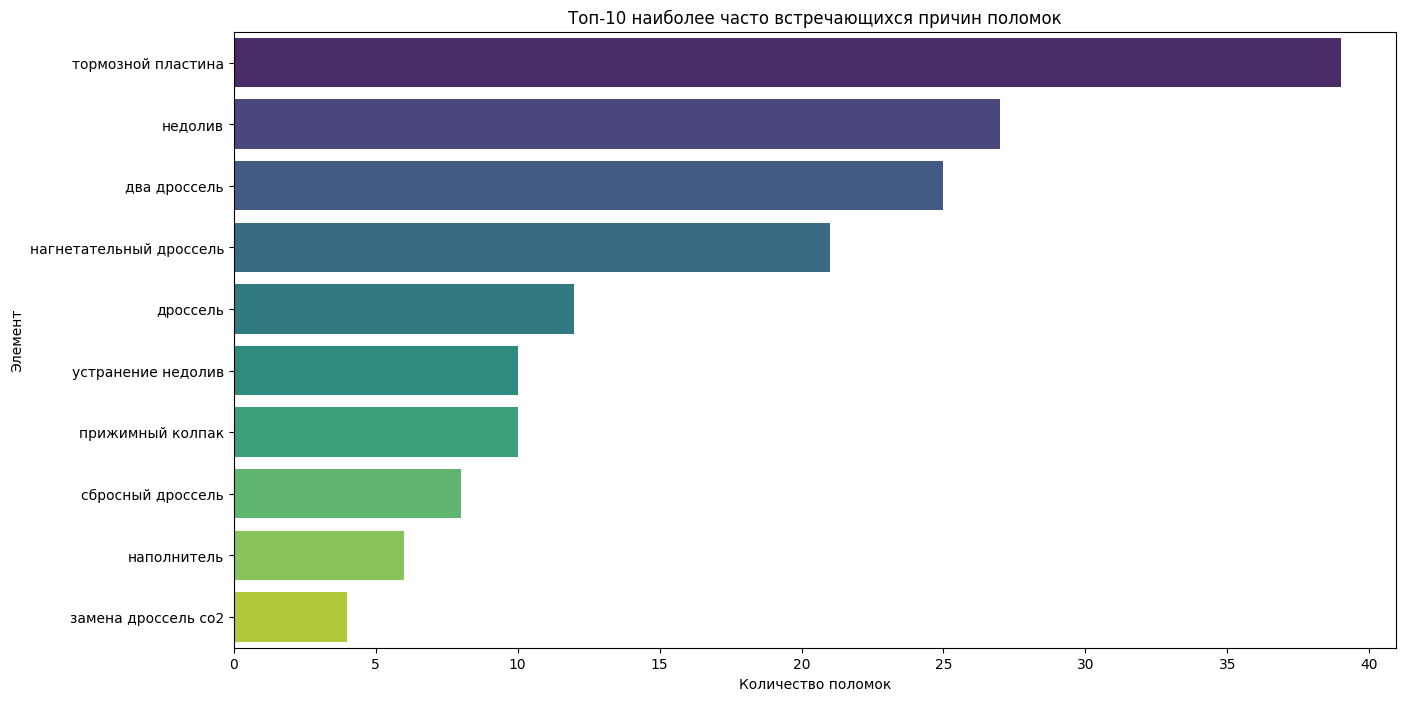

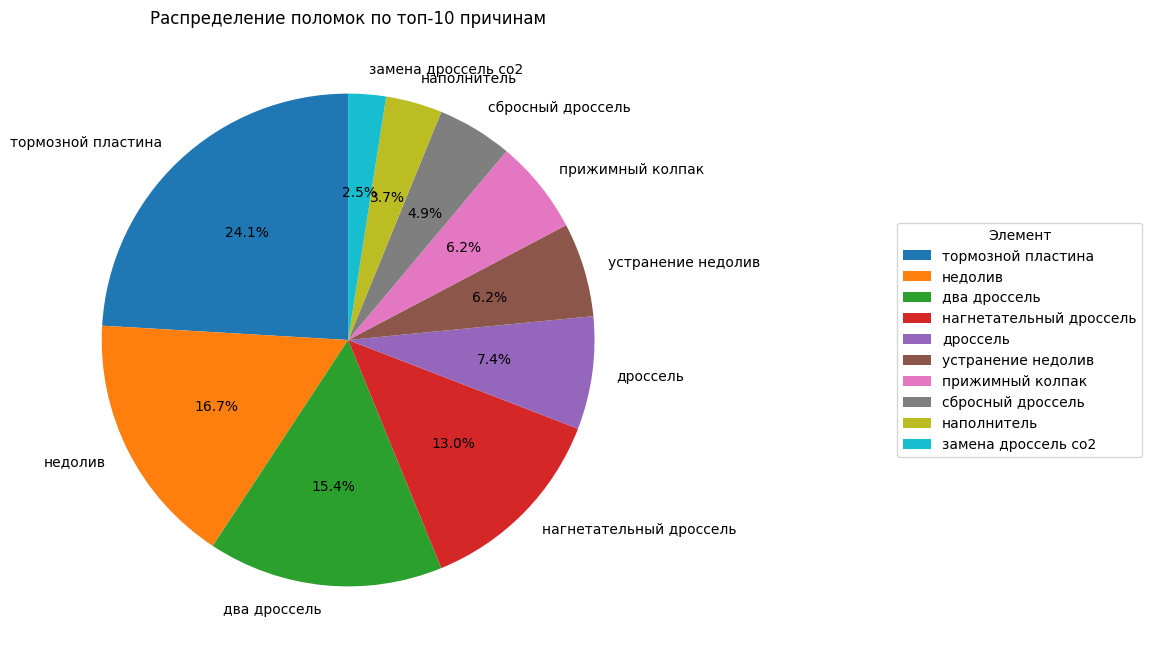

In [153]:
# Подсчет частоты поломок для каждого типа элемента
frequency_by_element = data['Элемент'].value_counts()

# Топ-10 наиболее часто встречающихся причин поломок
top_10_elements = frequency_by_element.head(10)

print("Топ-10 наиболее часто встречающихся причин поломок:")
print(top_10_elements)

plt.figure(figsize=(15, 8))
sns.barplot(x=top_10_elements.values, y=top_10_elements.index, palette='viridis')
plt.title('Топ-10 наиболее часто встречающихся причин поломок')
plt.xlabel('Количество поломок')
plt.ylabel('Элемент')
plt.show()

plt.figure(figsize=(20, 8))
top_10_elements.plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=top_10_elements.index, legend=True)
plt.title('Распределение поломок по топ-10 причинам')
plt.legend(title="Элемент", loc="right", bbox_to_anchor=(1.3, 0, 0.5, 1))
plt.ylabel('')
plt.show()

## Подмешивание шума  

Подмешаем нормальный шум в даннные таким образом, чтобы были в интвервалах не только поломки, но и нормальные данные. Это необходимо для классификационной модели по полмкам

In [154]:
data.reset_index(inplace=True)

In [155]:

# сгенерируем данные

from datetime import timedelta

normal_periods = []

for i in range(len(data) - 1):
    end_of_breakdown = data.loc[i, 'Конец простоя']
    start_of_next_breakdown = data.loc[i + 1, 'Начало простоя']
    
    # Если между поломками есть разрыв, создаем нормальные периоды
    if start_of_next_breakdown > end_of_breakdown:
        current_time = end_of_breakdown
        step = timedelta(minutes=30)  # Шаг для создания нормальных периодов (например, 30 минут)
        
        while current_time + step <= start_of_next_breakdown:
            normal_start = current_time
            normal_end = current_time + step
            normal_periods.append((normal_start, normal_end))
            current_time += step

normal_df = pd.DataFrame(normal_periods, columns=['Начало простоя', 'Конец простоя'])

normal_df['Метка'] = 'Нормальный'

data['Метка'] = 'Поломка'

combined_df = pd.concat([data[['Начало простоя', 'Конец простоя', 'Метка']], normal_df], ignore_index=True)



In [156]:
combined_df.sort_values('Начало простоя')

,Начало простоя,Конец простоя,Метка
0,2020-01-08 02:04:44,2020-01-08 02:08:29,Поломка
243,2020-01-08 02:08:29,2020-01-08 02:38:29,Нормальный
244,2020-01-08 02:38:29,2020-01-08 03:08:29,Нормальный
245,2020-01-08 03:08:29,2020-01-08 03:38:29,Нормальный
246,2020-01-08 03:38:29,2020-01-08 04:08:29,Нормальный
...,...,...,...
84710,2024-11-04 17:07:21,2024-11-04 17:37:21,Нормальный
84711,2024-11-04 17:37:21,2024-11-04 18:07:21,Нормальный
84712,2024-11-04 18:07:21,2024-11-04 18:37:21,Нормальный
84713,2024-11-04 18:37:21,2024-11-04 19:07:21,Нормальный


In [157]:
# проведём балансировку

from sklearn.utils import resample

# Разделяем данные на классы
breakdown_data = combined_df[combined_df['Метка'] == 'Поломка']
normal_data = combined_df[combined_df['Метка'] == 'Нормальный']


normal_downsampled = resample(
    normal_data,
    replace=False, 
    n_samples=len(breakdown_data),  
    random_state=42
)

balanced_df = pd.concat([breakdown_data, normal_downsampled], ignore_index=True)


balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df.head())

       Начало простоя       Конец простоя       Метка
0 2024-03-07 18:01:53 2024-03-07 18:31:53  Нормальный
1 2020-05-19 14:19:06 2020-05-19 14:49:06  Нормальный
2 2021-12-17 21:44:06 2021-12-17 22:14:06  Нормальный
3 2023-10-14 01:30:29 2023-10-14 02:00:29  Нормальный
4 2023-01-14 22:19:18 2023-01-14 22:49:18  Нормальный


In [158]:
# навелём суету

def add_noise_to_timestamps(timestamps, noise_level=5):
    """
    Добавляет случайный шум к временным меткам.
    :param timestamps: Pandas Series с временными метками.
    :param noise_level: Максимальное отклонение в минутах.
    :return: Pandas Series с измененными временными метками.
    """
    return timestamps + pd.to_timedelta(np.random.uniform(-noise_level, noise_level, size=len(timestamps)), unit='m')

# Применяем функцию к нормальным периодам
balanced_df.loc[balanced_df['Метка'] == 'Нормальный', 'Начало простоя'] = \
    add_noise_to_timestamps(balanced_df.loc[balanced_df['Метка'] == 'Нормальный', 'Начало простоя'])

balanced_df.loc[balanced_df['Метка'] == 'Нормальный', 'Конец простоя'] = \
    add_noise_to_timestamps(balanced_df.loc[balanced_df['Метка'] == 'Нормальный', 'Конец простоя'])

print(balanced_df.head())

                 Начало простоя                 Конец простоя       Метка
0 2024-03-07 17:57:55.406292524 2024-03-07 18:32:44.319126218  Нормальный
1 2020-05-19 14:16:21.157305324 2020-05-19 14:50:04.484646486  Нормальный
2 2021-12-17 21:45:31.321608162 2021-12-17 22:15:35.915838216  Нормальный
3 2023-10-14 01:26:18.737410910 2023-10-14 02:01:05.540076626  Нормальный
4 2023-01-14 22:19:55.733397198 2023-01-14 22:52:32.822788194  Нормальный


In [159]:
# переизвлеём признаки

# Извлекаем признаки
balanced_df['Час'] = balanced_df['Начало простоя'].dt.hour
balanced_df['День недели'] = balanced_df['Начало простоя'].dt.dayofweek
balanced_df['Продолжительность'] = (balanced_df['Конец простоя'] - balanced_df['Начало простоя']).dt.total_seconds() / 60  # В минутах

# Вычисляем время с последней поломки
balanced_df = balanced_df.sort_values(by='Начало простоя').reset_index(drop=True)
balanced_df['Время с последней поломки'] = (
    balanced_df['Начало простоя'] - balanced_df['Конец простоя'].shift(1)
).dt.total_seconds() / 60  # В минутах

# Заполнение NaN для первой строки
balanced_df['Время с последней поломки'].fillna(0, inplace=True)


/tmp/ipykernel_419662/2479877254.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  balanced_df['Время с последней поломки'].fillna(0, inplace=True)


In [160]:
balanced_df

,Начало простоя,Конец простоя,Метка,Час,День недели,Продолжительность,Время с последней поломки
0,2020-01-08 02:04:44.000000000,2020-01-08 02:08:29.000000000,Поломка,2,2,3.750000,0.000000
1,2020-01-21 16:09:33.283855579,2020-01-21 16:38:55.654368932,Нормальный,16,1,29.372842,19561.071398
2,2020-01-28 09:11:45.000000000,2020-01-28 09:20:46.000000000,Поломка,9,1,9.016667,9632.822427
3,2020-02-03 01:25:29.946098824,2020-02-03 01:46:45.919378648,Нормальный,1,0,21.266221,8164.732435
4,2020-02-05 10:40:01.000000000,2020-02-05 10:42:23.000000000,Поломка,10,2,2.366667,3413.251344
...,...,...,...,...,...,...,...
481,2024-10-20 10:31:14.492558060,2024-10-20 11:01:27.226780232,Нормальный,10,6,30.212237,4681.326588
482,2024-10-25 20:02:29.910288368,2024-10-25 20:36:06.131964920,Нормальный,20,4,33.603695,7741.044725
483,2024-10-27 19:36:59.396767796,2024-10-27 20:01:51.970525617,Нормальный,19,6,24.876229,2820.887747
484,2024-11-04 16:04:20.000000000,2024-11-04 16:07:21.000000000,Поломка,16,0,3.016667,11282.467158


In [161]:
balanced_df.to_excel('content/balanced_data_with_features.xlsx', index=False)

In [162]:
balanced_df = pd.read_excel('content/balanced_data_with_features.xlsx')

In [163]:
initial_df = pd.read_excel('content/Поломки_Блок Розлива_2020-2024v2.xlsx')

In [164]:
initial_df = initial_df.drop(initial_df.index[-1])

In [165]:
import locale
initial_df['Начало простоя'] = initial_df['Начало простоя'].apply(replace_month)
initial_df['Конец простоя'] = initial_df['Конец простоя'].apply(replace_month)


initial_df['Начало простоя'] = pd.to_datetime(initial_df['Начало простоя'], format='%d-%m-%y %H:%M:%S')
initial_df['Конец простоя'] = pd.to_datetime(initial_df['Конец простоя'], format='%d-%m-%y %H:%M:%S')


In [166]:
initial_df

,Начало простоя,Конец простоя,Reason 3 (ID),Reason 3 (ENG),Описание,Длительность
0,2020-01-08 02:04:44,2020-01-08 02:08:29,2010004.0,Breakdowns,Замена двух дросселей на наполнителе №17,3.750000
1,2020-01-28 09:11:45,2020-01-28 09:20:46,2010004.0,Breakdowns,Замена первого ролика на столике №1,9.016667
2,2020-02-05 10:40:01,2020-02-05 10:42:23,2010004.0,Breakdowns,Замена нагнетательного дросселя №89,2.366667
3,2020-02-06 10:59:58,2020-02-06 11:04:09,2010004.0,Breakdowns,Замена нагнетательного дросселя №105,4.183333
4,2020-02-06 19:02:48,2020-02-06 19:05:07,2010004.0,Breakdowns,Замена тормозной пластины №76,2.316667
...,...,...,...,...,...,...
526,2024-11-04 16:04:20,2024-11-04 16:07:21,2010004.0,Breakdowns,Замена тормозной пластины на 10 наполнителе.,3.016667
527,2024-11-04 19:15:34,2024-11-04 19:17:41,2010004.0,Breakdowns,Замена тормозной пластины на 66 наполнителе,2.100000
528,2024-11-05 09:48:48,2024-11-05 09:51:31,2010004.0,Breakdowns,замена тормозной пластины,2.716667
529,2024-11-21 03:12:49,2024-11-21 03:16:28,2010004.0,Breakdowns,МЕХ. Недолив. Пустые банки. 20/32/33/39,3.650000


In [167]:
balanced_df = pd.merge(balanced_df, initial_df[['Начало простоя', 'Описание']], on='Начало простоя', how='left')

In [168]:
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 0
    elif 12 <= hour < 18:
        return 1
    elif 18 <= hour < 24:
        return 2
    else:
        return 3

In [169]:

balanced_df['Час'] = balanced_df['Час'].apply(lambda x: get_time_of_day(x))

In [170]:
balanced_df = balanced_df.rename(columns={'Час': 'время дня'})

In [171]:
balanced_df['Описание'] = balanced_df['Описание'].fillna('Работа в нормальном режиме')

In [172]:
balanced_df['Метка'] = balanced_df['Метка'].apply(lambda x: 0 if x == 'Поломка' else 1)

In [173]:
balanced_df.columns

Index(['Начало простоя', 'Конец простоя', 'Метка', 'время дня', 'День недели',
       'Продолжительность', 'Время с последней поломки', 'Описание'],
      dtype='object')

In [174]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example DataFrame


# Step 1: Calculate MTBF
mtbf = balanced_df['Время с последней поломки'].mean()
print(f"Mean Time Between Failures (MTBF): {mtbf} hours")

# Step 2: Estimate Total Useful Life (e.g., 10x MTBF)
total_useful_life = 15 * mtbf
print(f"Estimated Total Useful Life: {total_useful_life} hours")

# Step 3: Calculate Remaining Resource
balanced_df['Остаточный ресурс'] = total_useful_life - balanced_df['Время с последней поломки']

# Display results


Mean Time Between Failures (MTBF): 5205.719954286752 hours
Estimated Total Useful Life: 78085.79931430129 hours


In [175]:
X_train_failure, X_test_failure, y_train_failure, y_test_failure= train_test_split(balanced_df[['время дня', 'День недели','Время с последней поломки']],balanced_df['Метка'] ,
                                   random_state=43,
                                   test_size=0.2,
                                   )

X_train_life_src, X_test_life_src, y_train_life_src, y_test_life_src= train_test_split(balanced_df[['время дня', 'День недели', 'Время с последней поломки']],balanced_df['Остаточный ресурс'] ,
                                   random_state=43,
                                   test_size=0.2,
                                   )

In [176]:
y_train_life_src

112    57784.892096
456    62996.589432
237    78066.949314
18     74999.546443
120    77807.056213
           ...     
277    75344.196297
305    63211.584759
255    71730.382648
320    78079.232648
324    76990.715981
Name: Остаточный ресурс, Length: 388, dtype: float64

In [177]:
# initial_df[["Элемент", "Номер"]] = initial_df["Описание"].apply(lambda x: pd.Series(parse_description(x)))

In [178]:
# from collections import Counter
#
# Counter(initial_df["Элемент"])

In [179]:
from catboost import  CatBoostClassifier

catboost_reg_clf = CatBoostClassifier(n_estimators=5, random_seed=42,learning_rate=0.5, early_stopping_rounds=50)
catboost_reg_clf.fit(X=X_train_failure, y=y_train_failure)

y_pred_failure = catboost_reg_clf.predict(X_test_failure)


0:	learn: 0.6237443	total: 6.13ms	remaining: 24.5ms
1:	learn: 0.5855749	total: 10.9ms	remaining: 16.3ms
2:	learn: 0.5636000	total: 14ms	remaining: 9.32ms
3:	learn: 0.5458337	total: 15.1ms	remaining: 3.77ms
4:	learn: 0.5377846	total: 15.9ms	remaining: 0us


In [180]:
from sklearn.metrics import f1_score, precision_score, recall_score
print(f1_score(y_pred_failure, y_test_failure))
print(precision_score(y_pred_failure, y_test_failure))
print(recall_score(y_pred_failure, y_test_failure))


0.7610619469026548
0.8958333333333334
0.6615384615384615


In [181]:
from sklearn.ensemble import VotingRegressor
from catboost import CatBoostRegressor
catboost_reg = CatBoostRegressor(n_estimators=5, random_seed=42, learning_rate=0.5,
    early_stopping_rounds=50)

catboost_reg.fit(X=X_train_life_src, y=y_train_life_src)

y_pred_life_src = catboost_reg.predict(X_test_life_src)


0:	learn: 4091.4317370	total: 1.92ms	remaining: 7.66ms
1:	learn: 2584.6844746	total: 3.58ms	remaining: 5.37ms
2:	learn: 1918.0715494	total: 4.87ms	remaining: 3.24ms
3:	learn: 1459.8092036	total: 5.79ms	remaining: 1.45ms
4:	learn: 1216.7492949	total: 6.88ms	remaining: 0us


In [182]:
catboost_reg

In [183]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print(r2_score(y_pred_life_src, y_test_life_src))
print(mean_absolute_error(y_pred_life_src, y_test_life_src))
print(mean_squared_error(y_pred_life_src, y_test_life_src))

0.862601981164554
793.5949909912023
4595013.509897303


In [184]:
# Вычисление ошибок
y_true = y_test_life_src
y_pred = y_pred_life_src
errors = np.abs(y_test_life_src - y_pred_life_src)  # Абсолютные ошибки
mae = np.mean(errors)
mae  # Среднее значение ошибок (MAE)

793.5949909912023

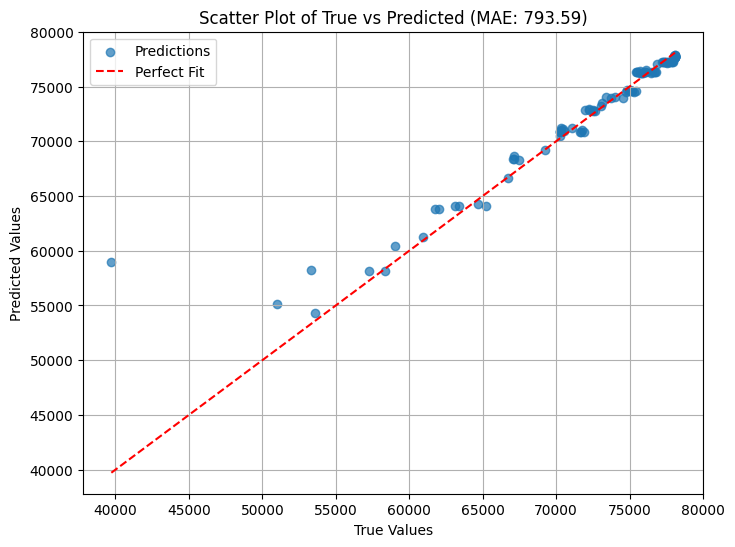

In [185]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.7, label='Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'Scatter Plot of True vs Predicted (MAE: {mae:.2f})')
plt.legend()
plt.grid(True)
plt.show()

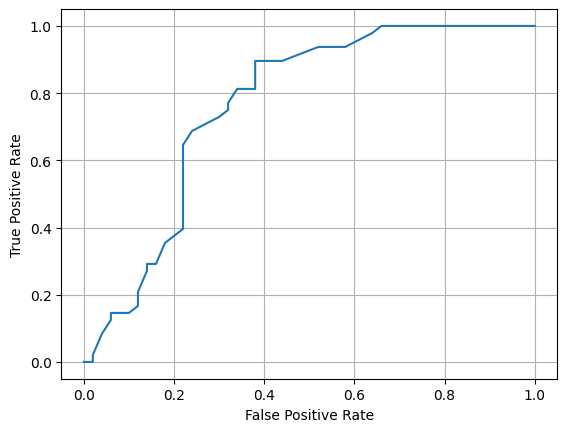

In [186]:
# roc- кривая
from sklearn import metrics

# Предсказания вероятностей
y_scores = catboost_reg_clf.predict_proba(X_test_failure)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test_failure,  y_scores)

# построение ROC кривой
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()
